# ---------------------------------------------------------------
# STAGE 2: CNN with L1 Regularisation to avoid pverfitting  and K-Fold Cross-Validation


In [1]:
# Import necessary libraries
import numpy as np
import tensorflow as tf
from sklearn.model_selection import KFold
from datasets import load_dataset

2025-04-16 19:49:52.838273: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-16 19:49:52.838388: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-16 19:49:52.838461: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-16 19:49:54.213549: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# loading and preprocessing 

In [2]:
# Fashion MNIST contains 60,000 grayscale images (28x28) for training
print("[INFO] Loading Fashion MNIST training set from Hugging Face...")
dataset = load_dataset("fashion_mnist")

# Convert images and labels into numpy arrays
X = np.array(dataset['train']['image'])           # Shape: (60000, 28, 28)
y = np.array(dataset['train']['label'])           # Labels: integers 0–9

# Normalize pixel values to range [0, 1]
X = X / 255.0

# Reshape into format expected by CNN: (num_samples, 28, 28, 1)
X = X.reshape(-1, 28, 28, 1)

# Log basic shape of data
print(f"[INFO] Loaded {X.shape[0]} images, input shape: {X.shape[1:]}")

[INFO] Loading Fashion MNIST training set from Hugging Face...
[INFO] Loaded 60000 images, input shape: (28, 28, 1)


# k fold for better generalisation 

In [3]:
# We'll use 5 folds, shuffle before splitting, and fix the seed for reproducibility
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

print(f"[INFO] Initializing {k}-fold cross-validation...")

[INFO] Initializing 5-fold cross-validation...


# l1 regulrisation to prevent overfitting with new model 

In [4]:
# ---------------------------------------------------------------
# Define a CNN model function with L1 regularisation
# ---------------------------------------------------------------

def create_l1_regularised_cnn(l1_lambda=0.001):
    """
    Creates a CNN model with L1 regularisation applied to convolutional layers.
    :param l1_lambda: strength of L1 penalty (regularisation coefficient)
    :return: compiled Keras model
    """

    # Use keras.regularizers.l1 to apply L1 weight penalty
    regularizer = tf.keras.regularizers.l1(l1_lambda)

    model = tf.keras.Sequential([
        # First convolutional block with L1 regularisation
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu',
                               kernel_regularizer=regularizer,
                               input_shape=(28, 28, 1)),
        tf.keras.layers.MaxPooling2D((2, 2)),

        # Second convolutional block
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu',
                               kernel_regularizer=regularizer),
        tf.keras.layers.MaxPooling2D((2, 2)),

        # Flatten and dense layers
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')  # 10 clothing categories
    ])

    # Compile the model with standard settings
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Training Loop with L1 + Metrics Logging

In [5]:
# ---------------------------------------------------------------
# Run K-Fold Training with L1 Regularisation and Track Metrics
# ---------------------------------------------------------------

# These lists will collect accuracy and loss values from each fold
fold_accuracies = []
fold_losses = []

# Keep track of the best performing model overall
best_accuracy = 0.0
best_model = None
X_val_best = None  # To store best model's validation set
y_val_best = None
best_fold_index = None  # To track which fold the best model came from

# Loop through each fold defined by the KFold splitter
for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    print(f"\n[INFO] Starting Fold {fold + 1}/{k}")

    # Extract training and validation data for this fold
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    # Create a new CNN model instance with L1 regularisation for this fold
    model = create_l1_regularised_cnn(l1_lambda=0.001)

    # Train the model using training data
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),  # Evaluate on validation during training
        epochs=10,
        batch_size=64,                   # Explicit batch size for control
        verbose=1                        # Show output per epoch
    )

    # Evaluate model on the validation set (get final accuracy and loss)
    val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)

    # Log metrics for this fold
    fold_accuracies.append(val_accuracy)
    fold_losses.append(val_loss)
    print(f"[RESULT] Fold {fold + 1} Accuracy: {val_accuracy:.4f}, Loss: {val_loss:.4f}")

    # If this model outperforms the previous best, update and save
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_model = model

        # Store the validation data of the best-performing fold
        X_val_best = X_val
        y_val_best = y_val
        best_fold_index = fold + 1

        # Save the best model to disk
        model.save("../models/stage2_fashion_cnn_best_l1.h5")
        print(f"[INFO] Best model updated and saved (Fold {fold + 1})")

# ---------------------------------------------------------------
# Final summary after completing all folds
# ---------------------------------------------------------------
print("\n[SUMMARY] Cross-Validation Complete")
print(f"Average Accuracy: {np.mean(fold_accuracies):.4f}")
print(f"Accuracy Std Dev: {np.std(fold_accuracies):.4f}")
print(f"Average Loss: {np.mean(fold_losses):.4f}")


[INFO] Starting Fold 1/5
Epoch 1/10
750/750 [==============================] - 17s 21ms/step - loss: 0.8170 - accuracy: 0.7844 - val_loss: 0.5611 - val_accuracy: 0.8404
Epoch 2/10
750/750 [==============================] - 18s 24ms/step - loss: 0.5213 - accuracy: 0.8492 - val_loss: 0.4937 - val_accuracy: 0.8522
Epoch 3/10
750/750 [==============================] - 18s 24ms/step - loss: 0.4580 - accuracy: 0.8627 - val_loss: 0.4400 - val_accuracy: 0.8686
Epoch 4/10
750/750 [==============================] - 18s 24ms/step - loss: 0.4200 - accuracy: 0.8747 - val_loss: 0.4099 - val_accuracy: 0.8780
Epoch 5/10
750/750 [==============================] - 17s 23ms/step - loss: 0.3979 - accuracy: 0.8787 - val_loss: 0.4010 - val_accuracy: 0.8773
Epoch 6/10
750/750 [==============================] - 18s 24ms/step - loss: 0.3809 - accuracy: 0.8826 - val_loss: 0.4008 - val_accuracy: 0.8750
Epoch 7/10
750/750 [==============================] - 17s 23ms/step - loss: 0.3652 - accuracy: 0.8872 - val_lo

/opt/jupyterhub/pyvenv/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/10
750/750 [==============================] - 19s 24ms/step - loss: 0.7848 - accuracy: 0.7835 - val_loss: 0.5531 - val_accuracy: 0.8340
Epoch 2/10
750/750 [==============================] - 18s 24ms/step - loss: 0.5159 - accuracy: 0.8447 - val_loss: 0.4815 - val_accuracy: 0.8509
Epoch 3/10
750/750 [==============================] - 18s 24ms/step - loss: 0.4573 - accuracy: 0.8615 - val_loss: 0.4427 - val_accuracy: 0.8648
Epoch 4/10
750/750 [==============================] - 17s 23ms/step - loss: 0.4233 - accuracy: 0.8686 - val_loss: 0.3931 - val_accuracy: 0.8814
Epoch 5/10
750/750 [==============================] - 17s 23ms/step - loss: 0.3990 - accuracy: 0.8759 - val_loss: 0.3897 - val_accuracy: 0.8829
Epoch 6/10
750/750 [==============================] - 18s 24ms/step - loss: 0.3816 - accuracy: 0.8812 - val_loss: 0.3678 - val_accuracy: 0.8860
Epoch 7/10
750/750 [==============================] - 17s 23ms/step - loss: 0.3665 - accuracy: 0.8846 - val_loss: 0.3531 - val_accuracy:

# cross validation best model confusion matrix


[INFO] Evaluating best model (from Fold 2)...
375/375 [==============================] - 3s 7ms/step


<Figure size 800x600 with 0 Axes>

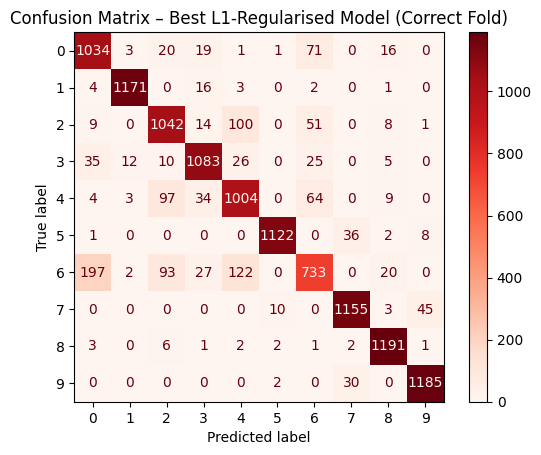

[RESULT] Accuracy of best saved model on validation set: 0.8933


In [7]:
# ---------------------------------------------------------------
# Evaluate Best Saved Model on Its Own Validation Fold
# ---------------------------------------------------------------

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt

# Load the best model from disk
best_model_loaded = tf.keras.models.load_model("../models/stage2_fashion_cnn_best_l1.h5")

# Print which fold produced the best model
print(f"\n[INFO] Evaluating best model (from Fold {best_fold_index})...")

# Predict class probabilities on the validation set used by that fold
y_pred_probs = best_model_loaded.predict(X_val_best)

# Convert predicted probabilities to actual class predictions (0–9)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Calculate confusion matrix using correct validation labels
conf_matrix = confusion_matrix(y_val_best, y_pred_classes)

# Calculate the final accuracy using the best fold’s validation set
best_model_accuracy = accuracy_score(y_val_best, y_pred_classes)


# Plot the confusion matrix for visual interpretation
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap="Reds", values_format="d")
plt.title("Confusion Matrix – Best L1-Regularised Model (Correct Fold)")
plt.grid(False)
plt.show()

# Print accuracy
print(f"[RESULT] Accuracy of best saved model on validation set: {best_model_accuracy:.4f}")
